<a href="https://colab.research.google.com/github/Only-Space/gestur-tangan-huruf/blob/main/gestur_tangan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import cv2
import torch
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import zipfile
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

# Menentukan lokasi file zip. Sesuaikan 'dataset.zip' jika nama file Anda berbeda.
zip_path = '/content/drive/MyDrive/dataset/hand gesture/dataset_gestur_huruf.zip'

# Membuka dan mengekstrak file zip
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    # Semua isi dari file zip akan diekstrak ke dalam folder bernama 'dataset'
    zip_ref.extractall('dataset')

# Menampilkan isi dari folder 'dataset' untuk memeriksa apakah ekstraksi berhasil
os.listdir('dataset')

['Test', 'Train']

In [4]:
# path dataset masing masing
PATH_DATASET = 'dataset'

In [5]:
PATH_TRAIN = os.path.join(PATH_DATASET, "Train")
LABELS = sorted(os.listdir(PATH_TRAIN))

label_mapping = {
    'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4,
    'F': 5, 'G': 6, 'H': 7, 'I': 8, 'K': 9,
    'L': 10, 'M': 11, 'N': 12, 'O': 13, 'P': 14,
    'Q': 15, 'R': 16, 'S': 17, 'T': 18, 'U': 19,
    'V': 20, 'W': 21, 'X': 22, 'Y': 23
}

inv_label_mapping = {v: k for k, v in label_mapping.items()}

RANDOM_SEED = 21

In [6]:
data = []
for label in LABELS:
    # loop untuk mencatat label dan path tiap gambar
    path_folder = PATH_TRAIN + "/" + label

    for file in os.listdir(path_folder):
        file_dict = {
            "label": label,
            "full_path": path_folder + "/" + file
        }
        data.append(file_dict)

df = pd.DataFrame(data)

In [7]:
df_train, df_val = train_test_split(df, test_size=0.2, random_state=RANDOM_SEED)

In [8]:
df_val

,label,full_path
621,A,dataset/Train/A/19884_A.jpg
23531,V,dataset/Train/V/7436_V.jpg
22834,U,dataset/Train/U/2000_U.jpg
24415,W,dataset/Train/W/5516_W.jpg
17769,Q,dataset/Train/Q/17925_Q.jpg
...,...,...
8857,I,dataset/Train/I/11024_I.jpg
22405,U,dataset/Train/U/19487_U.jpg
8959,I,dataset/Train/I/13529_I.jpg
5735,F,dataset/Train/F/749_F.jpg


In [9]:
# Hitung mean dan std dari dataset training Anda jika memungkinkan.
# Jika tidak, (0.5,) adalah default yang baik untuk data grayscale [0, 1].
DATA_MEAN = (0.5,)
DATA_STD = (0.5,)

# Transformasi untuk data latih (dengan augmentasi yang lebih kaya)
train_transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.RandomAffine(degrees=10, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.RandomHorizontalFlip(),
    transforms.Resize((28, 28)),
    transforms.ToTensor(),
    transforms.Normalize(mean=DATA_MEAN, std=DATA_STD) # Normalisasi
])


# Transformasi untuk data validasi (hanya preprocessing, termasuk normalisasi)
val_transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.Resize((28, 28)),
    transforms.ToTensor(),
    transforms.Normalize(mean=DATA_MEAN, std=DATA_STD) # Normalisasi harus sama
])

In [10]:
class CustomDataset(Dataset):
    def __init__(self, dataframe, transform=None): # Ditambahkan 'transform=None' untuk fleksibilitas
        self.data = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Menggunakan 'full_path' sesuai dengan kode Anda
        img_path = self.data.iloc[idx]['full_path']
        label_str = self.data.iloc[idx]['label']
        # Using the correct label mapping
        label = label_mapping[label_str]

        # .convert('L') untuk Grayscale, ini sudah tepat sekali!
        image = Image.open(img_path).convert('L')

        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(label, dtype=torch.long) # .long() sudah benar


# --- KODE SPLITTING (Dijalankan terlebih dahulu) ---
# Removed dummy data creation and splitting


# --- BAGIAN PENGGABUNGAN ---

# 3. Definisikan transformasi Anda
# Using the transforms defined in cell Ty0TqRxfvA9t
# train_transform = transforms.Compose([
#     transforms.RandomHorizontalFlip(),
#     transforms.RandomRotation(10),
#     transforms.ToTensor(),
#     transforms.Normalize((0.5,), (0.5,))
# ])

# val_transform = transforms.Compose([
#     transforms.ToTensor(),
#     transforms.Normalize((0.5,), (0.5,))
# ])

# 4. Buat DUA instance CustomDataset menggunakan DataFrame yang sudah di-split
train_dataset = CustomDataset(dataframe=df_train, transform=train_transform)
val_dataset = CustomDataset(dataframe=df_val, transform=val_transform)

In [11]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

print(f"✅ Berhasil! Siap untuk training.")
print(f"Ukuran train_dataset: {len(train_dataset)} sampel")
print(f"Ukuran val_dataset: {len(val_dataset)} sampel")

✅ Berhasil! Siap untuk training.
Ukuran train_dataset: 21964 sampel
Ukuran val_dataset: 5491 sampel


In [12]:
class CNN(nn.Module):
    def __init__(self, num_classes=24):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout2d(0.25),

            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),  # Corrected from 32 to 64
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout2d(0.25),

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128), # Corrected from 32 to 128
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.25),

        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 3 * 3, 256), nn.ReLU(), nn.Dropout(0.5), # Corrected dropout probability
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        return self.classifier(self.features(x))

In [13]:
def train_model(model, train_loader, val_loader, epochs, device, patience=7):
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    # --- MODIFIKASI 1: Menambahkan weight_decay ---
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

    # --- MODIFIKASI 2: Variabel untuk Early Stopping ---
    best_val_loss = np.inf # Kita lacak loss, karena lebih sensitif daripada akurasi
    patience_counter = 0
    best_model_path = "best_model.pth" # File untuk menyimpan model terbaik

    print("🚀 Memulai proses training...")
    for epoch in range(epochs):
        # ... (Bagian training loop tetap sama) ...
        model.train()
        train_loss, train_correct, total = 0, 0, 0
        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} [Train]", leave=False):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, preds = outputs.max(1)
            train_correct += (preds == labels).sum().item()
            total += labels.size(0)

        # ... (Bagian validation loop tetap sama, tapi kita hitung rata-rata loss) ...
        val_loss, val_correct = 0, 0
        model.eval()
        with torch.no_grad():
            for images, labels in tqdm(val_loader, desc=f"Epoch {epoch+1}/{epochs} [Val]", leave=False):
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, preds = outputs.max(1)
                val_correct += (preds == labels).sum().item()

        # Hitung metrik rata-rata
        avg_train_loss = train_loss / len(train_loader)
        avg_val_loss = val_loss / len(val_loader)
        train_acc = 100 * train_correct / len(train_loader.dataset)
        val_acc = 100 * val_correct / len(val_loader.dataset)

        print(f"Epoch {epoch+1}/{epochs} | Train Acc: {train_acc:.2f}% | Val Acc: {val_acc:.2f}% | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")

        # --- MODIFIKASI 2: Logika Early Stopping ---
        # Cek apakah validation loss membaik
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), best_model_path)
            print(f"✅ Val loss membaik! Model terbaik disimpan di '{best_model_path}'")
            patience_counter = 0 # Reset counter
        else:
            patience_counter += 1
            print(f"⚠️ Val loss tidak membaik. Counter: {patience_counter}/{patience}")

        # Hentikan training jika patience sudah habis
        if patience_counter >= patience:
            print(f"🛑 Early stopping terpicu di Epoch {epoch+1}. Training dihentikan.")
            break # Keluar dari loop

    print("🏁 Training selesai.")
    # Opsional: Muat kembali bobot model terbaik setelah training selesai
    model.load_state_dict(torch.load(best_model_path))
    return model

In [14]:
!nvidia-smi

Thu Aug 21 12:08:54 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   60C    P8             11W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [15]:
import torch

# 1. Definisikan arsitektur model (harus sama p ersis dengan saat menyimpan)
model = CNN(num_classes=24)

# 2. Tentukan path ke file checkpoint Anda
# Ganti nama file jika Anda menggunakan nama yang berbeda
checkpoint_path = "checkpoint_epoch.pth"

# 3. Muat bobot dari checkpoint ke dalam model
# Baris ini akan menimpa bobot acak model dengan bobot yang sudah terlatih
try:
    model.load_state_dict(torch.load(checkpoint_path))
    print(f"✅ Bobot dari checkpoint '{checkpoint_path}' berhasil dimuat.")
    start_epoch = 0 # You might want to save and load the epoch number too
except FileNotFoundError:
    print(f"❌ Checkpoint file '{checkpoint_path}' not found. Training from scratch.")
    start_epoch = 0


# 4. Siapkan device dan pindahkan model ke device
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f'Menggunakan device: {device}')
model.to(device)

# 5. Lanjutkan pelatihan atau lakukan evaluasi
epochs = 40
print(f"Melanjutkan pelatihan selama {epochs} epoch...")
train_model(model, train_loader, val_loader, epochs, device)

# Simpan model final setelah pelatihan selesai
torch.save(model.state_dict(), "cnn_handsign_model_final.pth")
print("\n🎉 Pelatihan selesai! Model final diperbarui.")

❌ Checkpoint file 'checkpoint_epoch.pth' not found. Training from scratch.
Menggunakan device: cuda:0
Melanjutkan pelatihan selama 40 epoch...
🚀 Memulai proses training...


Epoch 1/40 | Train Acc: 25.16% | Val Acc: 66.00% | Train Loss: 2.3373 | Val Loss: 1.1114
✅ Val loss membaik! Model terbaik disimpan di 'best_model.pth'


Epoch 2/40 | Train Acc: 49.89% | Val Acc: 81.59% | Train Loss: 1.4461 | Val Loss: 0.6273
✅ Val loss membaik! Model terbaik disimpan di 'best_model.pth'


Epoch 3/40 | Train Acc: 59.30% | Val Acc: 86.60% | Train Loss: 1.1547 | Val Loss: 0.4220
✅ Val loss membaik! Model terbaik disimpan di 'best_model.pth'


Epoch 4/40 | Train Acc: 65.09% | Val Acc: 89.35% | Train Loss: 0.9833 | Val Loss: 0.3566
✅ Val loss membaik! Model terbaik disimpan di 'best_model.pth'


Epoch 5/40 | Train Acc: 69.19% | Val Acc: 92.97% | Train Loss: 0.8821 | Val Loss: 0.2484
✅ Val loss membaik! Model terbaik disimpan di 'best_model.pth'


Epoch 6/40 | Train Acc: 71.80% | Val Acc: 94.37% | Train Loss: 0.7907 | Val Loss: 0.1987
✅ Val loss membaik! Model terbaik disimpan di 'best_model.pth'


Epoch 7/40 | Train Acc: 73.95% | Val Acc: 96.96% | Train Loss: 0.7371 | Val Loss: 0.1601
✅ Val loss membaik! Model terbaik disimpan di 'best_model.pth'


Epoch 8/40 | Train Acc: 76.08% | Val Acc: 95.79% | Train Loss: 0.6825 | Val Loss: 0.1541
✅ Val loss membaik! Model terbaik disimpan di 'best_model.pth'


Epoch 9/40 | Train Acc: 77.80% | Val Acc: 98.23% | Train Loss: 0.6231 | Val Loss: 0.1012
✅ Val loss membaik! Model terbaik disimpan di 'best_model.pth'


Epoch 10/40 | Train Acc: 79.65% | Val Acc: 97.23% | Train Loss: 0.5800 | Val Loss: 0.1085
⚠️ Val loss tidak membaik. Counter: 1/7


Epoch 11/40 | Train Acc: 81.39% | Val Acc: 98.22% | Train Loss: 0.5427 | Val Loss: 0.0791
✅ Val loss membaik! Model terbaik disimpan di 'best_model.pth'


Epoch 12/40 | Train Acc: 81.59% | Val Acc: 98.89% | Train Loss: 0.5197 | Val Loss: 0.0657
✅ Val loss membaik! Model terbaik disimpan di 'best_model.pth'


Epoch 13/40 | Train Acc: 83.21% | Val Acc: 98.89% | Train Loss: 0.4808 | Val Loss: 0.0576
✅ Val loss membaik! Model terbaik disimpan di 'best_model.pth'


Epoch 14/40 | Train Acc: 84.56% | Val Acc: 99.24% | Train Loss: 0.4467 | Val Loss: 0.0408
✅ Val loss membaik! Model terbaik disimpan di 'best_model.pth'


Epoch 15/40 | Train Acc: 85.45% | Val Acc: 99.47% | Train Loss: 0.4237 | Val Loss: 0.0354
✅ Val loss membaik! Model terbaik disimpan di 'best_model.pth'


Epoch 16/40 | Train Acc: 86.03% | Val Acc: 99.20% | Train Loss: 0.4027 | Val Loss: 0.0378
⚠️ Val loss tidak membaik. Counter: 1/7


Epoch 17/40 | Train Acc: 87.24% | Val Acc: 99.58% | Train Loss: 0.3766 | Val Loss: 0.0242
✅ Val loss membaik! Model terbaik disimpan di 'best_model.pth'


Epoch 18/40 | Train Acc: 87.67% | Val Acc: 99.47% | Train Loss: 0.3624 | Val Loss: 0.0244
⚠️ Val loss tidak membaik. Counter: 1/7


Epoch 19/40 | Train Acc: 88.42% | Val Acc: 99.69% | Train Loss: 0.3407 | Val Loss: 0.0147
✅ Val loss membaik! Model terbaik disimpan di 'best_model.pth'


Epoch 20/40 | Train Acc: 89.26% | Val Acc: 99.65% | Train Loss: 0.3162 | Val Loss: 0.0147
✅ Val loss membaik! Model terbaik disimpan di 'best_model.pth'


Epoch 21/40 | Train Acc: 89.71% | Val Acc: 99.85% | Train Loss: 0.3027 | Val Loss: 0.0124
✅ Val loss membaik! Model terbaik disimpan di 'best_model.pth'


Epoch 22/40 | Train Acc: 90.19% | Val Acc: 99.71% | Train Loss: 0.2869 | Val Loss: 0.0128
⚠️ Val loss tidak membaik. Counter: 1/7


Epoch 23/40 | Train Acc: 90.89% | Val Acc: 99.78% | Train Loss: 0.2778 | Val Loss: 0.0109
✅ Val loss membaik! Model terbaik disimpan di 'best_model.pth'


Epoch 24/40 | Train Acc: 91.39% | Val Acc: 99.96% | Train Loss: 0.2567 | Val Loss: 0.0077
✅ Val loss membaik! Model terbaik disimpan di 'best_model.pth'


Epoch 25/40 | Train Acc: 91.38% | Val Acc: 99.89% | Train Loss: 0.2569 | Val Loss: 0.0085
⚠️ Val loss tidak membaik. Counter: 1/7


Epoch 26/40 | Train Acc: 92.18% | Val Acc: 99.95% | Train Loss: 0.2339 | Val Loss: 0.0056
✅ Val loss membaik! Model terbaik disimpan di 'best_model.pth'


Epoch 27/40 | Train Acc: 92.56% | Val Acc: 99.84% | Train Loss: 0.2303 | Val Loss: 0.0073
⚠️ Val loss tidak membaik. Counter: 1/7


Epoch 28/40 | Train Acc: 92.57% | Val Acc: 100.00% | Train Loss: 0.2276 | Val Loss: 0.0039
✅ Val loss membaik! Model terbaik disimpan di 'best_model.pth'


Epoch 29/40 | Train Acc: 92.77% | Val Acc: 99.76% | Train Loss: 0.2169 | Val Loss: 0.0075
⚠️ Val loss tidak membaik. Counter: 1/7


Epoch 30/40 | Train Acc: 93.23% | Val Acc: 99.95% | Train Loss: 0.2063 | Val Loss: 0.0044
⚠️ Val loss tidak membaik. Counter: 2/7


Epoch 31/40 | Train Acc: 93.13% | Val Acc: 99.91% | Train Loss: 0.2021 | Val Loss: 0.0056
⚠️ Val loss tidak membaik. Counter: 3/7


Epoch 32/40 | Train Acc: 93.60% | Val Acc: 99.91% | Train Loss: 0.1953 | Val Loss: 0.0036
✅ Val loss membaik! Model terbaik disimpan di 'best_model.pth'


Epoch 33/40 | Train Acc: 93.74% | Val Acc: 100.00% | Train Loss: 0.1840 | Val Loss: 0.0016
✅ Val loss membaik! Model terbaik disimpan di 'best_model.pth'


Epoch 34/40 | Train Acc: 93.86% | Val Acc: 100.00% | Train Loss: 0.1867 | Val Loss: 0.0027
⚠️ Val loss tidak membaik. Counter: 1/7


Epoch 35/40 | Train Acc: 93.84% | Val Acc: 99.98% | Train Loss: 0.1862 | Val Loss: 0.0023
⚠️ Val loss tidak membaik. Counter: 2/7


Epoch 36/40 | Train Acc: 94.35% | Val Acc: 99.98% | Train Loss: 0.1767 | Val Loss: 0.0020
⚠️ Val loss tidak membaik. Counter: 3/7


Epoch 37/40 | Train Acc: 94.51% | Val Acc: 99.98% | Train Loss: 0.1682 | Val Loss: 0.0027
⚠️ Val loss tidak membaik. Counter: 4/7


Epoch 38/40 | Train Acc: 94.62% | Val Acc: 99.96% | Train Loss: 0.1662 | Val Loss: 0.0022
⚠️ Val loss tidak membaik. Counter: 5/7


Epoch 39/40 | Train Acc: 94.61% | Val Acc: 99.96% | Train Loss: 0.1663 | Val Loss: 0.0026
⚠️ Val loss tidak membaik. Counter: 6/7


Epoch 40/40 | Train Acc: 94.50% | Val Acc: 100.00% | Train Loss: 0.1624 | Val Loss: 0.0012
✅ Val loss membaik! Model terbaik disimpan di 'best_model.pth'
🏁 Training selesai.

🎉 Pelatihan selesai! Model final diperbarui.


In [16]:
import torch
import torch.nn as nn
from tqdm.notebook import tqdm
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def evaluate_model(model, loader, device, criterion, class_names):
    """
    Fungsi untuk mengevaluasi model pada dataset.

    Args:
        model (nn.Module): Model yang akan dievaluasi.
        loader (DataLoader): DataLoader untuk data evaluasi (validasi atau tes).
        device (str): Device untuk komputasi ('cuda' atau 'cpu').
        criterion: Fungsi loss (misalnya, nn.CrossEntropyLoss()).
        class_names (list): Daftar nama kelas untuk laporan dan plot.
    """
    model.to(device)
    model.eval() # Set model ke mode evaluasi

    total_loss = 0.0
    all_preds = []
    all_labels = []
    incorrect_samples = []

    with torch.no_grad(): # Tidak perlu menghitung gradien saat evaluasi
        for images, labels in tqdm(loader, desc="Evaluating"):
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            # Dapatkan prediksi
            _, preds = outputs.max(1)

            # Kumpulkan semua prediksi dan label untuk laporan nanti
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            # Kumpulkan sampel yang salah prediksi (jika diperlukan)
            for i in range(len(labels)):
                if preds[i] != labels[i]:
                    incorrect_samples.append((images[i].cpu(), preds[i].cpu(), labels[i].cpu()))

    # --- Hitung Metrik Keseluruhan ---
    avg_loss = total_loss / len(loader)
    accuracy = 100 * (np.array(all_preds) == np.array(all_labels)).sum() / len(all_labels)

    print(f"\n--- Hasil Evaluasi ---")
    print(f"Average Loss: {avg_loss:.4f}")
    print(f"Accuracy: {accuracy:.2f}%\n")

    # --- Tampilkan Laporan Klasifikasi Rinci ---
    print("Classification Report:")
    print(classification_report(all_labels, all_preds, target_names=class_names, zero_division=0))

    # --- Tampilkan Confusion Matrix ---
    print("Confusion Matrix:")
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

    return incorrect_samples, avg_loss, accuracy

In [17]:
import os
import pandas as pd
from pathlib import Path
from torch.utils.data import DataLoader

def create_test_loader(test_dir, transform, batch_size=64):
    """
    Membuat DataLoader untuk set data tes.

    Args:
        test_dir (str): Path ke direktori tes utama (misalnya, '.../Dataset/Test').
        transform (callable): Transformasi yang akan diterapkan pada gambar.
        batch_size (int): Ukuran batch untuk DataLoader.

    Returns:
        DataLoader: DataLoader untuk data tes.
    """
    # Menggunakan pathlib untuk menangani path dan mencari file gambar
    # Ini lebih modern dan tahan terhadap perbedaan OS (Windows/Linux/Mac)
    test_path = Path(test_dir)

    # Mencari semua file dengan ekstensi .jpg, .jpeg, atau .png di semua subfolder
    # Ini mencegah file non-gambar (seperti .DS_Store atau thumbs.db) ikut terbaca
    image_paths = list(test_path.glob('*/*.[jp][pn]g'))

    # Ekstrak label dari nama folder induk
    labels = [p.parent.name for p in image_paths]

    # Buat DataFrame
    df_test = pd.DataFrame({
        'full_path': image_paths,
        'label': labels
    })

    if df_test.empty:
        print(f"Peringatan: Tidak ada file gambar yang ditemukan di '{test_dir}'")
        return None

    print(f"Total file gambar tes yang ditemukan: {len(df_test)}")

    # Buat CustomDataset dan DataLoader
    # Pastikan kelas CustomDataset Anda bisa menerima path object dari pathlib
    test_dataset = CustomDataset(df_test, transform)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return test_loader

# --- Cara Penggunaan ---
# Asumsikan PATH_TEST, val_transform, dan CustomDataset sudah ada

# Definisikan direktori tes Anda
PATH_TEST = os.path.join(PATH_DATASET, "Test")

# Buat test_loader menggunakan fungsi baru
test_loader = create_test_loader(PATH_TEST, val_transform, batch_size=64)

# Cek apakah loader berhasil dibuat
if test_loader:
    print("✅ test_loader berhasil dibuat.")

Evaluating: 100%|██████████| 113/113 [00:04<00:00, 24.46it/s]


Accuracy: 99.96%
3


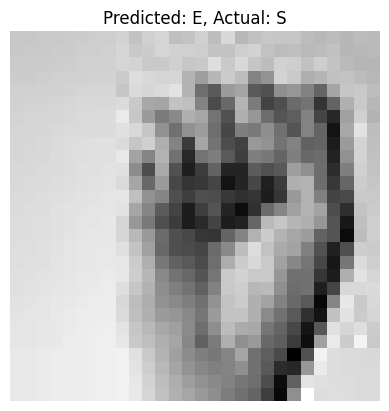

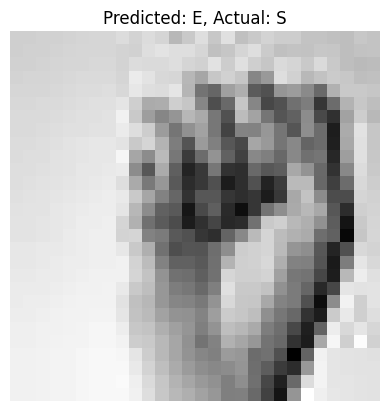

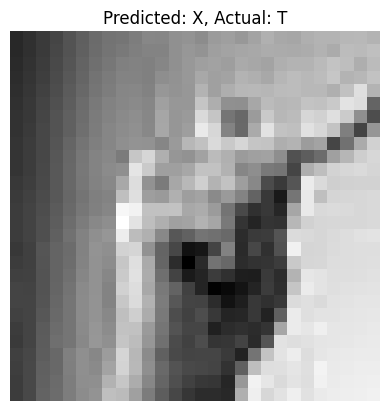

In [18]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

# --- Pastikan semua variabel ini sudah didefinisikan sebelumnya ---
# model: model Anda yang sudah dilatih dengan bobot terbaik.
# test_loader: DataLoader untuk data tes Anda.
# inv_label_mapping: kamus untuk mengubah label integer ke string (misal, {0: 'A', 1: 'B', ...}).
# class_names: daftar nama kelas sesuai urutan label integer.
# device: 'cuda' atau 'cpu'.

# 1. Definisikan criterion untuk perhitungan loss
criterion = nn.CrossEntropyLoss()

# 2. Panggil fungsi evaluate_model yang sudah ditingkatkan
# Fungsi ini membutuhkan semua argumen dan mengembalikan 3 nilai.
incorrect_samples, final_loss, final_accuracy = evaluate_model(
    model=model,
    loader=test_loader,
    device=device,
    criterion=criterion,
    class_names=class_names
)

print("-" * 50)
print(f"Ditemukan {len(incorrect_samples)} prediksi yang salah dari total {len(test_loader.dataset)} data tes.")

# 3. Visualisasikan beberapa sampel yang salah (menggunakan logika Anda)
print("Menampilkan hingga 5 contoh prediksi yang salah:")
# Loop ini aman bahkan jika gambar yang salah kurang dari 5
for i in range(min(5, len(incorrect_samples))):
    img, pred, label = incorrect_samples[i]

    # Tips: Denormalisasi gambar agar visualnya lebih jelas
    # Jika Anda menggunakan transforms.Normalize((0.5,), (0.5,)):
    # img = img * 0.5 + 0.5

    plt.imshow(img.squeeze(), cmap='gray')
    plt.title(f"Prediksi: {inv_label_mapping[pred.item()]}\nAktual: {inv_label_mapping[label.item()]}")
    plt.axis('off')
    plt.show()